# Set Up

In [23]:
# Importing Google Drive
from google.colab import drive
drive.mount('content/', force_remount = True)

FOLDERNAME = "vehicle-re-identification"

import sys
sys.path.append('content/MyDrive/{}'.format(FOLDERNAME))
path = 'content/MyDrive/{}'.format(FOLDERNAME)

Mounted at content/


In [25]:
# Common imports
import os
import matplotlib as plt

# PyTorch
import torch
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Importing local files
import constants as c
from model.losses import OtLoss, ClfLoss 
from dataloader.dataloader import load_dataset, DataloaderIterator
from model.net import FeatExt, ClfModel
from training.train import train_model
from evaluation.eval import compute_gallery_score,compare_query,index_to_gallery_label

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Function to plot images
def imshow(inp, title=None, norm=True):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [27]:
# Global Variables
c.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c.batch_size = 128
c.eval_every = 1

# Load Datasets

In [28]:
# Create the dataset
source_cam = ['c001', 'c002', 'c006', 'c010', 'c011',
              'c013', 'c014', 'c015', 'c017', 'c019']
target_cam = ['c003', 'c004', 'c005', 'c007', 'c008', 'c009', 'c012', 'c016']

#source_cam = ['c001']
#target_cam = ['c003']
source_train_gen, source_test_gen, source_val_gen, \
target_train_gen, target_test_gen, target_val_gen = load_dataset(c.veri_root,
                                                                 source_cam,
                                                                 target_cam)

dataset_size = {'source_train': len(source_train_gen),
                'source_test': len(source_test_gen),
                'source_val': len(source_val_gen),
                'target_train': len(target_train_gen),
                'target_test': len(target_test_gen),
                'target_val': len(target_val_gen)}

# Create the dataloader
source_loader = {'train': DataLoader(source_train_gen, shuffle=True, drop_last=True, 
                                     batch_size=c.batch_size, num_workers=c.workers),
                 'val': DataLoader(source_val_gen, drop_last=True,
                                   batch_size=c.batch_size, num_workers=c.workers),
                 'test' : DataLoader(source_test_gen, batch_size=c.batch_size,
                                     num_workers=c.workers)}
target_loader = {'train': DataLoader(target_train_gen, shuffle=True, drop_last=True, 
                                     batch_size=c.batch_size, num_workers=c.workers),
                 'val': DataLoader(target_val_gen, drop_last=True,
                                   batch_size=c.batch_size, num_workers=c.workers),
                 'test' : DataLoader(target_test_gen, batch_size=c.batch_size,
                                     num_workers=c.workers)}
target_iter = {'train': DataloaderIterator(target_loader['train']),
               'val': DataloaderIterator(target_loader['val']),
               'test' : DataloaderIterator(target_loader['test'])}

In [175]:
# Make a first run on the dataset so they start downloading the images
next(iter(source_loader['train']))
next(iter(source_loader['val']))
next(iter(target_loader['train']))
next(iter(target_loader['val']))
print('Dataloader is working :D')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff376248710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


Dataloader is working :D


In [30]:
# Download a pretrained model
pretrained_model = models.resnet18(pretrained=True)

# Load Models

### Load the Source Trained Model

In [152]:
# Load the checkpoint for our supervised-trained models.
source_feature_extractor = FeatExt(pretrained_model)
source_classifier = ClfModel(list(pretrained_model.children())[-1].in_features)

checkpoint = torch.load(os.path.join(
    'content/MyDrive/vehicle-re-identification/training/model_checkpoints/checkpoint_source_model.pth'))
source_feature_extractor.load_state_dict(
    checkpoint['best_feature_extractor_state_dict'])
source_classifier.load_state_dict(checkpoint['best_classifier_state_dict'])
source_train_logger = checkpoint['train_logger']
source_val_logger = checkpoint['val_logger']

source_feature_extractor.to(device=c.device)
source_classifier.to(device=c.device)

source_feature_extractor.eval()
source_classifier.eval()

ClfModel(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=775, bias=True)
  (relu): ReLU()
)

### Load the Source/Target DeepJDOT Model

In [153]:
# Load the DeepJDOT-trained model.
djdot_feature_extractor = FeatExt(pretrained_model)
djdot_classifier = ClfModel(list(pretrained_model.children())[-1].in_features)

checkpoint = torch.load(os.path.join(
    'content/MyDrive/vehicle-re-identification/training/model_checkpoints/checkpoint_mixed_model.pth'))
djdot_feature_extractor.load_state_dict(
    checkpoint['best_feature_extractor_state_dict'])
djdot_classifier.load_state_dict(checkpoint['best_classifier_state_dict'])
djdot_train_logger = checkpoint['train_logger']
djdot_val_logger = checkpoint['val_logger']

djdot_feature_extractor.to(device=c.device)
djdot_classifier.to(device=c.device)

djdot_feature_extractor.eval()
djdot_classifier.eval()

ClfModel(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=775, bias=True)
  (relu): ReLU()
)

# Evaluation

### Testing in source test dataset

In [154]:
c.num_feat = 512

In [155]:
# Creating the dataset and the iterator
queryloader = DataLoader(source_test_gen, batch_size=1, shuffle=True, num_workers=c.workers)
# Compute the distance matrix
gallery = compute_gallery_score(source_feature_extractor, 512, queryloader, c.device)
iterator = iter(queryloader)

### Computing gallery matrix ###
 99  %complete
### finished ###


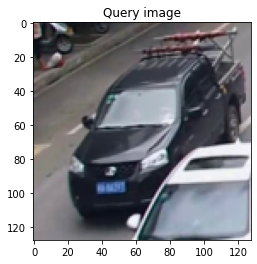

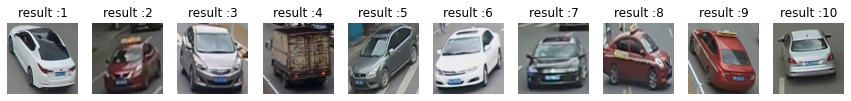

In [156]:
# Making a query
xt, _ = iterator.next()
plt.figure()
plt.title('Query image') 
plt.imshow(np.transpose(vutils.make_grid(xt, normalize=True),(1,2,0)))
index = compare_query(source_feature_extractor, xt, gallery, c.num_feat,
                      c.device, ranking=True)
my_labels = index_to_gallery_label(index, source_test_gen)

### Testing in target test dataset

In [157]:
# Creating the dataset and the iterator
queryloader = DataLoader(target_test_gen, batch_size=1, num_workers=c.workers)
# Compute the distance matrix
gallery = compute_gallery_score(source_feature_extractor, 512, queryloader, c.device)
iterator = iter(queryloader)

### Computing gallery matrix ###
 99  %complete
### finished ###


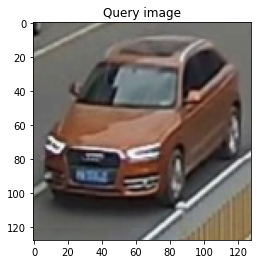

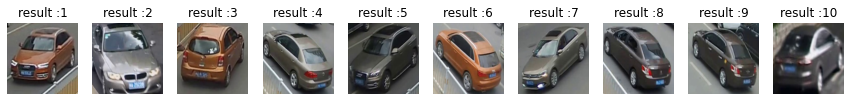

In [159]:
# Making a query
xt, _ = iterator.next()
plt.figure()
plt.title('Query image') 
plt.imshow(np.transpose(vutils.make_grid(xt, normalize=True),(1,2,0)))
index = compare_query(source_feature_extractor, xt, gallery, c.num_feat,
                      c.device, ranking=True)
my_labels = index_to_gallery_label(index, target_test_gen)

# Evaluation on (Source + Target) Model

This section should be executed with model only trained with DeepJDOT training


### Testing on Source Test Data

In [165]:
# Creating the dataset and the iterator
queryloader = DataLoader(source_test_gen, batch_size=1, num_workers=c.workers)
# Compute the distance matrix
gallery_JDOT = compute_gallery_score(djdot_feature_extractor, 512, source_loader_evaluation, c.device)
iterator = iter(queryloader)

### Computing gallery matrix ###
 99  %complete
### finished ###


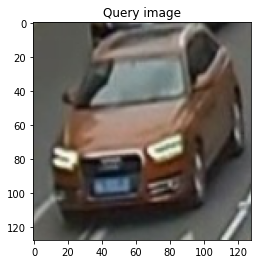

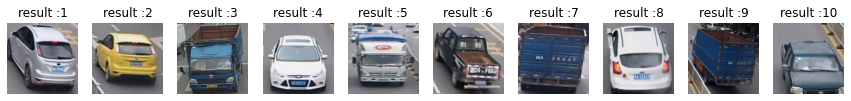

In [174]:
# Making a query
xt, _ = iterator.next()
plt.figure()
plt.title('Query image') 
plt.imshow(np.transpose(vutils.make_grid(xt, normalize=True),(1,2,0)))
index = compare_query(djdot_feature_extractor, xt, gallery, c.num_feat,
                      c.device, ranking=True)
my_labels = index_to_gallery_label(index, source_test_gen)

### Testing on the target dataset

In [162]:
# Creating the dataset and the iterator
queryloader = DataLoader(target_test_gen, batch_size=1, num_workers=c.workers)
# Compute the distance matrix
gallery = compute_gallery_score(djdot_feature_extractor, 512, queryloader, c.device)

### Computing gallery matrix ###
 99  %complete
### finished ###


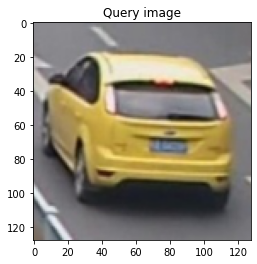

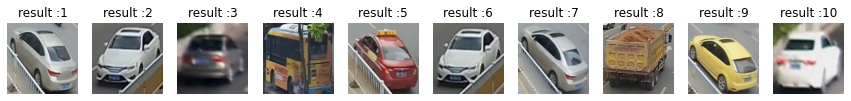

In [163]:
# Making a query
xt, _ = iterator.next()
plt.figure()
plt.title('Query image') 
plt.imshow(np.transpose(vutils.make_grid(xt, normalize=True),(1,2,0)))
index = compare_query(djdot_feature_extractor, xt, gallery, c.num_feat,
                      c.device, ranking=True)
my_labels = index_to_gallery_label(index, target_test_gen)